# Energy Consumption | Time Series Forecasting


Data: A time series containing weekly information for electricity consumption in the East Region of the United States
<a href="https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption"> Source: PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States </a>

<h2> Steps: </h2>

1) Statistical analyses on time series data using Python

Checking for stationarity, unit root, seasonality, trend and autocorrelation



### <font color='CornflowerBlue'>1 - <ins> Importing libraries</ins>: <font color='violet'></font>

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews

In [5]:
from pandas.plotting import register_matplotlib_converters #Seasonal-Trend decomposition using LOESS (STL)

In [6]:
df = pd.read_csv("PJME_hourly.csv")


### <font color='CornflowerBlue'>2- <ins> EDA </ins>: <font color='violet'></font>

In [12]:
df.head(5)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [13]:
df.shape

(145366, 2)

In [14]:
for col in df:
    print(sum(pd.isnull(df[col])))

0
0


In [11]:
df.columns = df.columns.str.lower()
df.dtypes

datetime     object
pjme_mw     float64
dtype: object

In [12]:
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

In [13]:
color_pal = sns.color_palette("Set2")

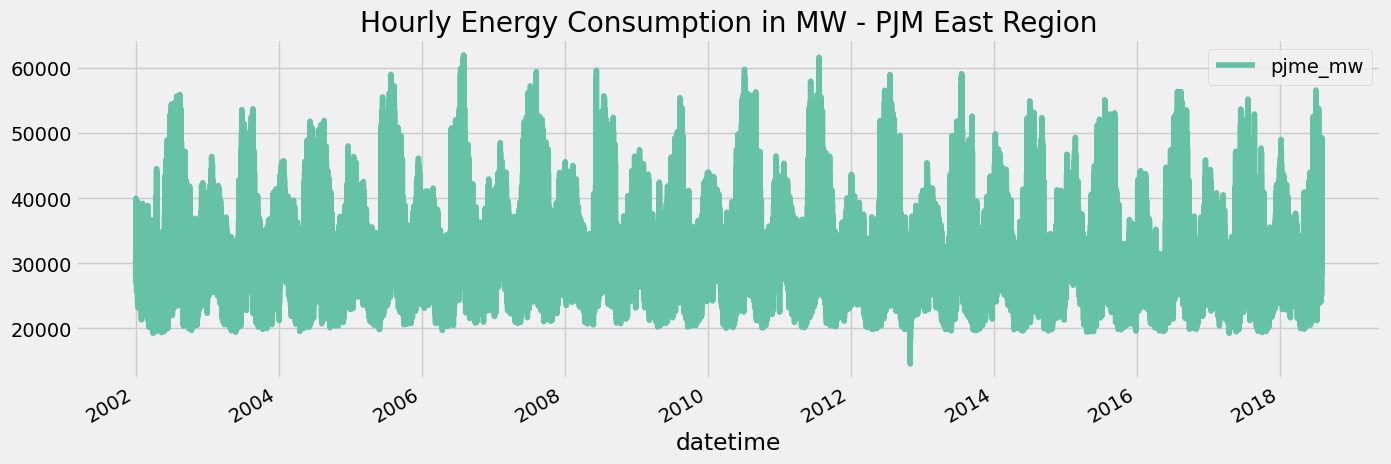

In [14]:
df.plot(figsize= (15,5),
        color=color_pal[0],
        title='Hourly Energy Consumption in MW - PJM East Region')
plt.show()

## <center><font color='CornflowerBlue'>3-<ins> Checking for Stationarity <font color='CornflowerBlue'><ins><center>

 ### <font color='CornflowerBlue'>A-<ins> Checking for Stationarity with Augmented Dickey-Fuller test (ADF) <font color='CornflowerBlue'>


Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [19]:
from statsmodels.tsa.stattools import adfuller

In [20]:
X = df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.828913
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [7]:
# ADF test
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [22]:
adf_test(X)

Results of Dickey-Fuller Test:
Test Statistic                -1.882891e+01
p-value                        2.022125e-30
#Lags Used                     7.400000e+01
Number of Observations Used    1.452910e+05
Critical Value (1%)           -3.430395e+00
Critical Value (5%)           -2.861560e+00
Critical Value (10%)          -2.566781e+00
dtype: float64


p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

 ### <font color='CornflowerBlue'>B- </ins> Checking for Stationarity with Kwiatkowski-Phillips-Schmidt-Shin test for stationarity (KPSS) </ins>: <font color='violet'></font>


In [23]:
from statsmodels.tsa.stattools import kpss

Null hypothesis (H0): that the process is trend stationary

Alternate hypothesis(H1): the series has a unit root (series is not stationary).

In [24]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [25]:
kpss_test(df)

Results of KPSS Test:
Test Statistic             1.176234
p-value                    0.010000
Lags Used                162.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


C:\Users\rober\AppData\Local\Temp\ipykernel_23420\11026176.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [26]:
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

In [27]:
kpss(np.random.choice(range(-1000,1000),10000))

(0.23229822878363293,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [28]:
kpss(X, regression='c', nlags='auto', store=False)

(1.1762342370829708,
 0.01,
 162,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

#### Conclusion: ADF does not find a unit root; but KPSS claims that it is non-stationary. Then, the series is difference stationary. 

(at least one of the tests claims to have found non-stationarity, differencing must be used.)

## <center><font color='CornflowerBlue'>4-<ins> Checking for Seasonality & Trend <font color='CornflowerBlue'><ins><center>

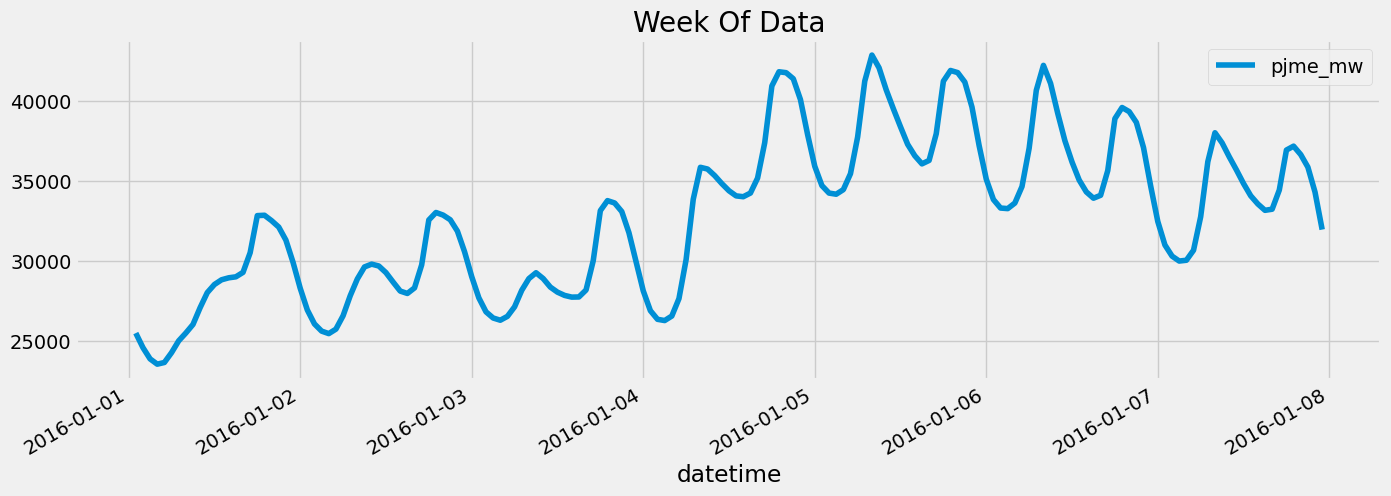

In [15]:
df.loc[(df.index > '01-01-2016') & (df.index < '01-08-2016')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

 ### <font color='CornflowerBlue'>B- </ins> Seasonal-Trend decomposition using LOESS (STL) </ins>: <font color='violet'></font> 

a) STL Decomposition plot

In [33]:
#from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

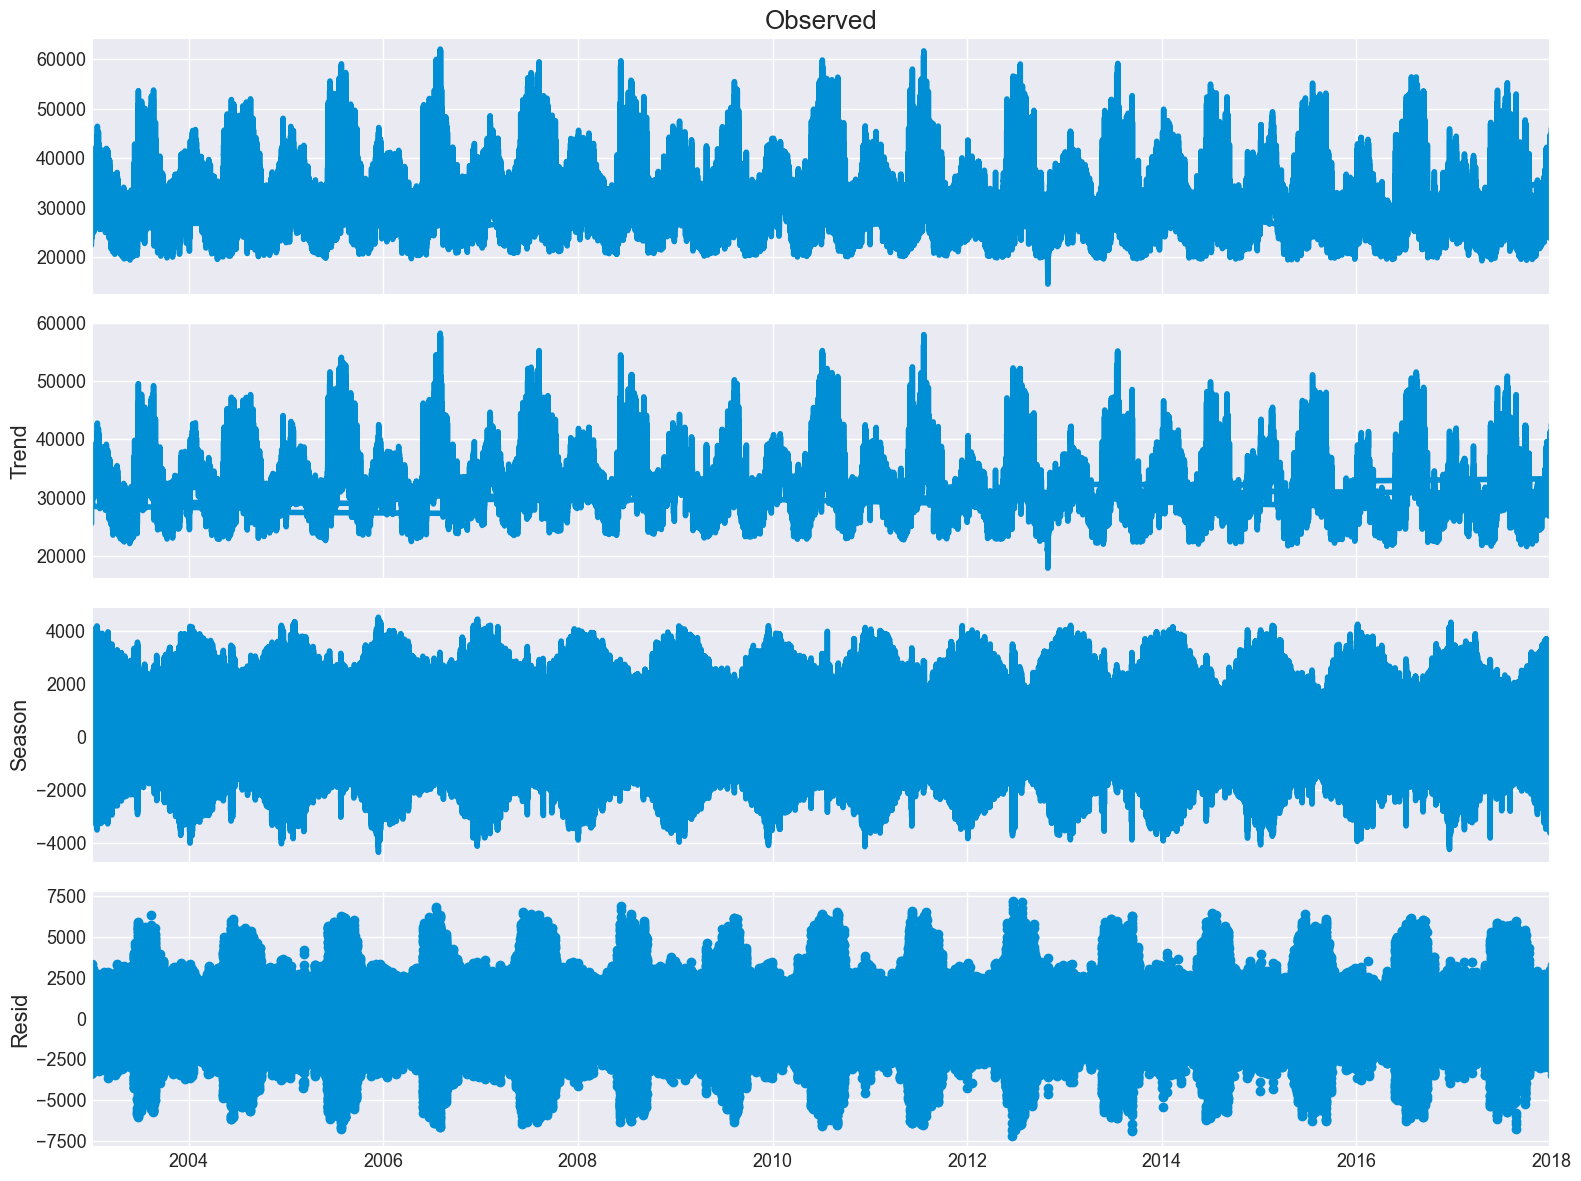

In [35]:

from statsmodels.tsa.seasonal import STL


res = STL(df, period=12).fit()
res.plot()
plt.savefig('plots/STL.png',dpi=300, bbox_inches='tight' )
plt.show()

b) Mandall-Kendall trend Test

## <center><font color='CornflowerBlue'>5-<ins> Checking for Autocorrelation <font color='CornflowerBlue'><ins><center>

a) Autocorrelation Fonction Plot

b) Partial Correlation Fonction Plot

c) Durbin - Watson Statistic

## <center><font color='CornflowerBlue'>5-<ins> Feature Creation <font color='CornflowerBlue'><ins><center>

In [16]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df2 = create_features(df)


In [36]:
df.columns

Index(['pjme_mw', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

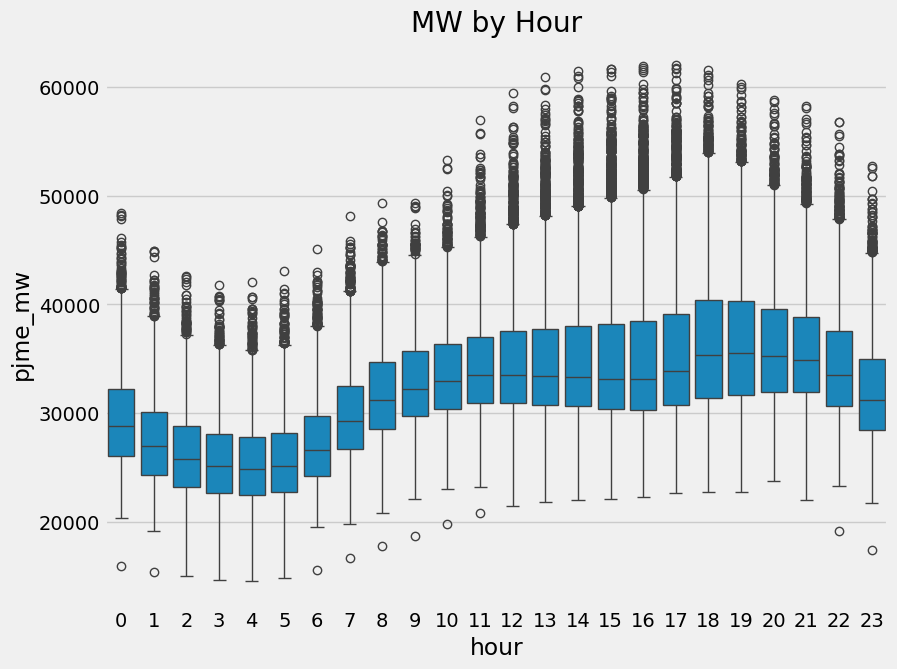

In [26]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.boxplot(data=df2, x='hour', y='pjme_mw')
ax.set_title('MW by Hour')
plt.savefig('plots/mw_hour.png', dpi=300, bbox_inches='tight')


plt.show()

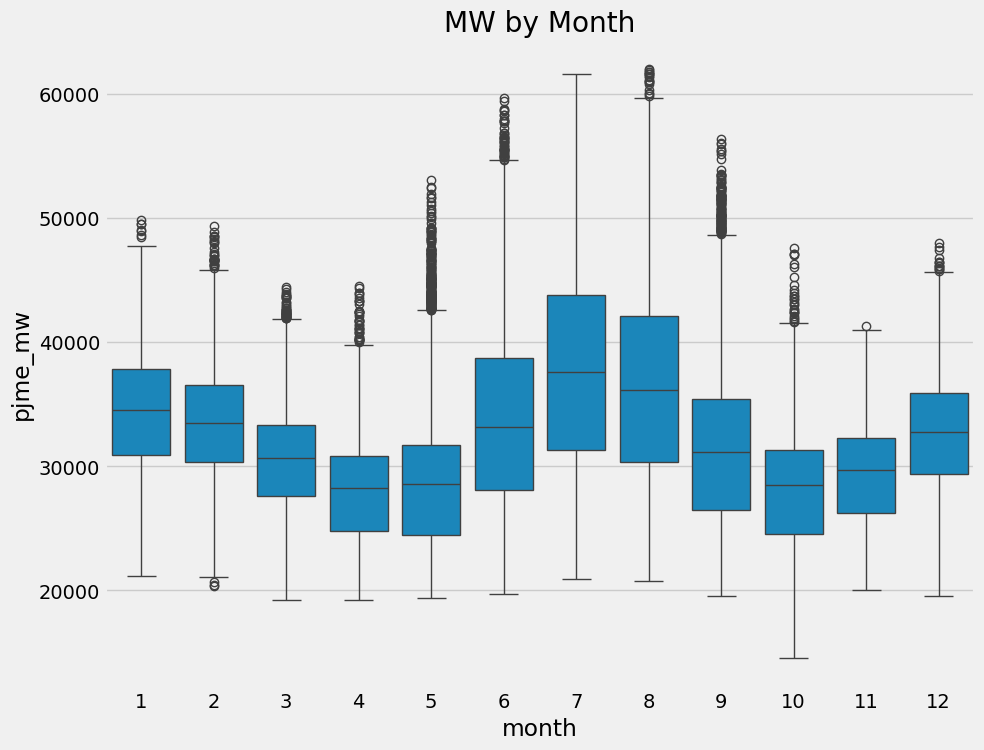

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='month', y='pjme_mw')
ax.set_title('MW by Month')
plt.savefig('plots/mw_month.png', dpi=300, bbox_inches='tight')

plt.show()

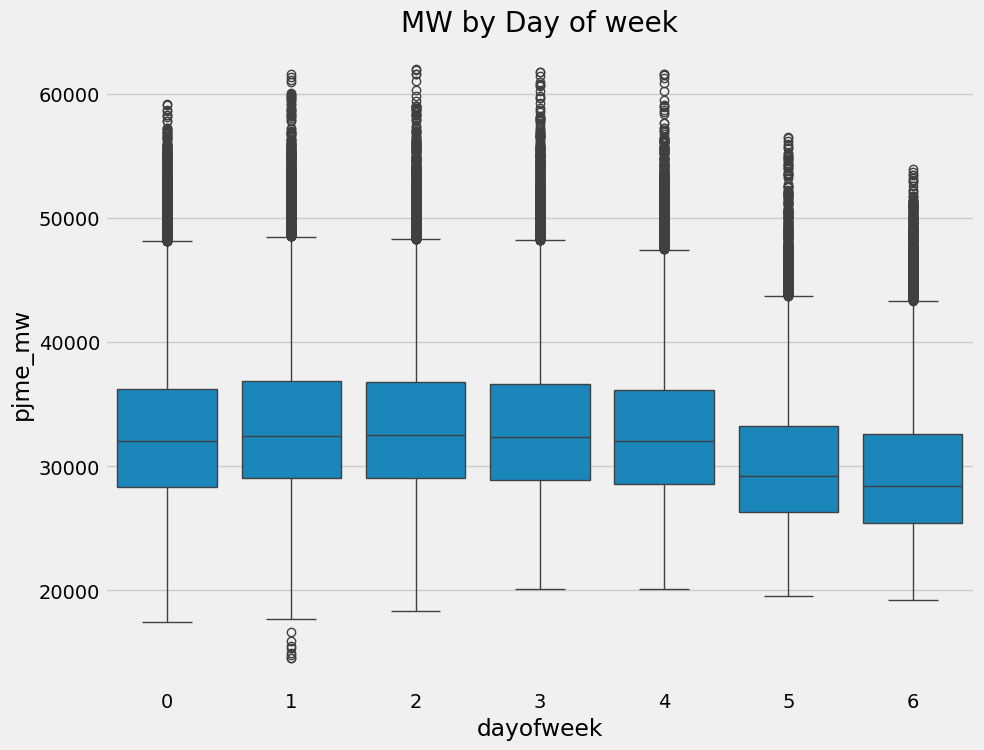

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='dayofweek', y='pjme_mw')
ax.set_title('MW by Day of week')
plt.savefig('plots/mw_day_week.png', dpi=300, bbox_inches='tight')

plt.show()

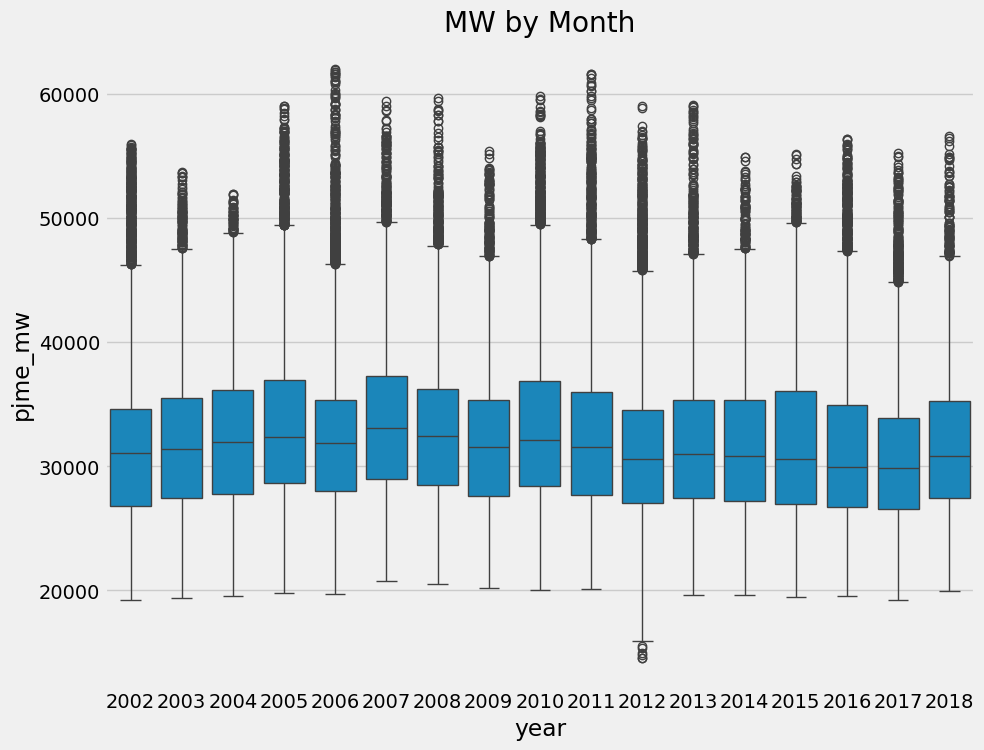

In [29]:
fig, ax = plt.subplots (figsize = (10, 8))
sns.boxplot(data=df2, x='year', y='pjme_mw')
ax.set_title('MW by Month')
plt.savefig('plots/mw_month.png', dpi=300, bbox_inches='tight')

plt.show()
